In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
print("Using tensorflow version: " + tf.__version__)
print("Using eager execution: " + str(tf.executing_eagerly())) 

Using tensorflow version: 2.1.0
Using eager execution: True


In [2]:
import pathlib
from PIL import Image
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = "../dataset"

masked_faces_paths = list(pathlib.Path(DATASET_PATH + "/masked_faces").glob('*'))
normal_faces_paths = list(pathlib.Path(DATASET_PATH + "/normal_faces").glob('*'))

length = len(masked_faces_paths)
print(f"Total number of samples: {length}")

split_ratio = 0.8
training_size = int(split_ratio * length)
validation_size = length - training_size
print(f"Dataset training size: {training_size} | Dataset validation size: {validation_size}")

training_paths = masked_faces_paths[:training_size] + normal_faces_paths[:training_size]
validation_paths = masked_faces_paths[training_size:] + normal_faces_paths[training_size:]

targets = None
with open(DATASET_PATH + "/targets.json") as json_file:
			targets = json.load(json_file)

Total number of samples: 680
Dataset training size: 544 | Dataset validation size: 136


'masked_faces'

{'bbox': [[194, 246, 656, 708]]}

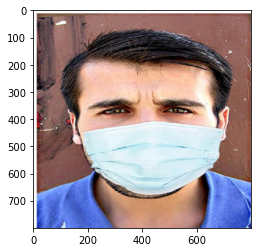

In [4]:
image_path = training_paths[2]
image_name = str(image_path).split(os.sep)[3]
str(image_path).split(os.sep)[2]
targets[image_name]
image = Image.open(image_path).convert("RGB")
plt.imshow(image)


In [ ]:
def get_model():
    pass

In [ ]:
def get_dataset():
    pass

In [ ]:
def compute_loss(
    model,
    data,
    labels
):
    pass

In [ ]:
def evaluate_model(
    model,
    validation_dataset
):
    for x, y in training_dataset:
        predictions = model(x)

In [ ]:
def train_step(
    model,
    data,
    labels,
    optimizer,
    clip_gradients_value = None
):
    with tf.GradientTape as tape:
        losses_dict = compute_loss(model, data, labels)
        total_loss = losses_dict["total_loss"]

    trainable_variables = model.trainable_variables
    gradients = tape.gradients(total_loss, trainable_variables)

    if clip_gradients_value is not None:
        gradients, _ = tf.clip_by_global_norm(gradients, clip_gradients_value)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return total_loss 

In [6]:
def train_loop(config):
    epochs = config["epochs"]
    learning_rate = config["learning_rate"]
    clip_gradients_value = if "clip_gradients_value" in config else None
    evaluation_interval = if "evaluation_interval" in  config["evaluation_interval"] else 1
    metrics_interval = if "metrics_interval" in config["metrics_interval"] else5

    model = get_model()
    training_dataset, validation_dataset = get_dataset()

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    train_losses = []
    epoch_loss_avg = tf.keras.metrics.Mean()

    print("Start training!")
    for epoch in range(epochs):

        for x, y in training_dataset:
            total_loss = train_step(
                model,
                x, y,
                optimizer,
                clip_gradients_value
            )

            epoch_loss_avg(total_loss)

        train_loss_results.append(epoch_loss_avg.result())

		if epoch % metrics_interval == 0:
			print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

        if epoch % evaluation_interval == 0:
		    evaluate_model(model, validation_dataset)

        epoch_loss_avg.reset_states()

    return model

In [ ]:
config = {
    "epochs": 10,
    "learning_rate": 0.001
}

trained_model =train_loop(config)